CarND Vehicle Detection Project
---
---

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.
---

## Import Libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
import time

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip

%matplotlib inline

## Histogram of Oriented Gradients (HOG)

### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

#### Load the data

In [2]:
images_vehicle  = glob.glob('../dataset/vehicles/vehicles/**/*.png')
images_nonvehicle = glob.glob('../dataset/non-vehicles/non-vehicles/**/*.png')

print("images for vehicles: {}".format(len(images_vehicle)))
print("images for non-vehicles: {}".format(len(images_nonvehicle)))

images for vehicles: 8792
images for non-vehicles: 8968


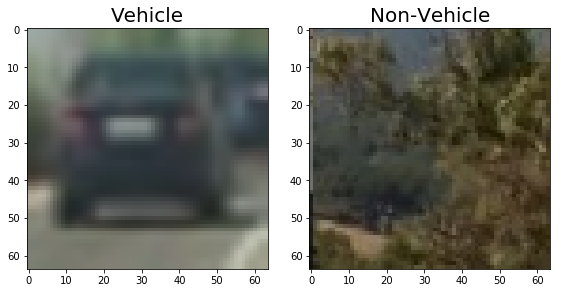

In [3]:
img_vehicle_1 = mpimg.imread(images_vehicle[0])
img_nonvehicle_1 = mpimg.imread(images_nonvehicle[1])

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(8, 8))
f.tight_layout()
ax1.imshow(img_vehicle_1)
ax1.set_title('Vehicle', fontsize=20)
ax2.imshow(img_nonvehicle_1)
ax2.set_title('Non-Vehicle', fontsize=20)

#### Extract HOG features

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

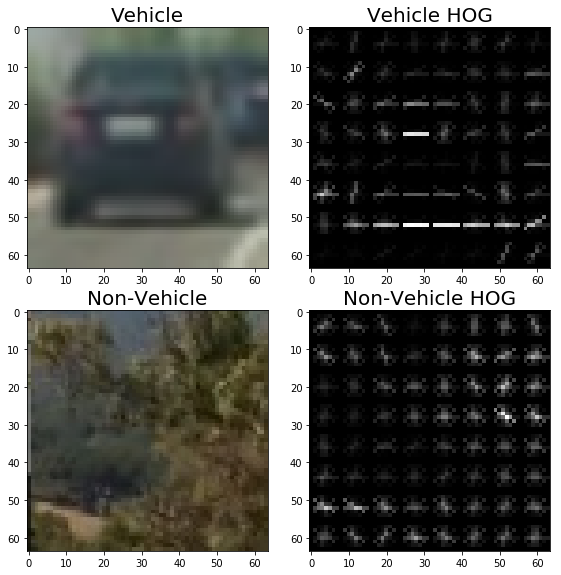

In [5]:
img_vehicle_1 = mpimg.imread(images_vehicle[0])
img_nonvehicle_1 = mpimg.imread(images_nonvehicle[1])

_, img_vehicle_1_hog = get_hog_features(img_vehicle_1[:,:,2], orient=9, pix_per_cell=8, cell_per_block=2, 
                                     vis=True, feature_vec=True)
_, img_nonvehicle_1_hog = get_hog_features(img_nonvehicle_1[:,:,2], orient=9, pix_per_cell=8, cell_per_block=2, 
                                     vis=True, feature_vec=True)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8))
f.tight_layout()
ax1.imshow(img_vehicle_1)
ax1.set_title('Vehicle', fontsize=20)
ax2.imshow(img_vehicle_1_hog, cmap='gray')
ax2.set_title('Vehicle HOG', fontsize=20)
ax3.imshow(img_nonvehicle_1)
ax3.set_title('Non-Vehicle', fontsize=20)
ax4.imshow(img_nonvehicle_1_hog, cmap='gray')
ax4.set_title('Non-Vehicle HOG', fontsize=20)

In [6]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_size=(32, 32), hist_bins=32,
                     spatial_feat=False, hist_feat=False, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [7]:
def extract_data(cars, notcars, color_space, orient, pix_per_cell, cell_per_block, hog_channel,
                     spatial_size=(32, 32), hist_bins=32, spatial_feat=True, hist_feat=True, hog_feat=True):
    
    car_features = extract_features(cars, color_space=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   spatial_size=spatial_size, hist_bins=hist_bins,
                                   spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   spatial_size=spatial_size, hist_bins=hist_bins,
                                   spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)    
    
    return X_train, X_test, y_train, y_test

### 2. Explain how you settled on your final choice of HOG parameters.

In [8]:
def train_predict(X_train, X_test, y_train, y_test):
    # Use a linear SVC 
    svc = LinearSVC()
  
    svc.fit(X_train, y_train)

    # Check the score of the SVC
    test_accuracy = round(svc.score(X_test, y_test), 4)
    
    return test_accuracy

In [9]:
def parameters_selection(images_vehicle, images_nonvehicle, parameters):
    
    template = "{label:^5}|{colorspace:^15}|{orient:^15}|{pix_per_cell:^15}|{cell_per_block:^15}|{hog_channel:^15}|{accuracy:^10}|{time:^5}"
    
    print(template.format(
        label="label", colorspace="colorspace", orient="orient", pix_per_cell="pix_per_cell", cell_per_block="cell_per_block",
        hog_channel='hog_channel', accuracy='accuracy', time='time'
    ))

    for value in parameters:
        color_space = value['colorspace']
        orient = value['orient']
        pix_per_cell = value['pix_per_cell']
        cell_per_block = value['cell_per_block']
        hog_channel = value['hog_channel']
        spatial_size = (32, 32)
        hist_bins = 32
        spatial_feat = True
        hist_feat = True
        hog_feat = True

        t=time.time()
        X_train, X_test, y_train, y_test = extract_data(images_vehicle, images_nonvehicle, 
                                                     color_space, orient, pix_per_cell, cell_per_block, hog_channel,
                                                     spatial_size, hist_bins, 
                                                     spatial_feat, hist_feat, hog_feat)
        test_accuracy = train_predict(X_train, X_test, y_train, y_test)
        t2 = time.time()    
        time_cost = t2-t

        value['accuracy'] = test_accuracy
        value['time'] = int(time_cost)

        print(template.format(**value))

In [18]:
parameters1 = [
    {'label':1, 'colorspace':'RGB', 'orient':9, 'pix_per_cell':8, 'cell_per_block':2, 'hog_channel':'ALL', 'accuracy':0.0, 'time':0.0},
    {'label':2, 'colorspace':'HSV', 'orient':9, 'pix_per_cell':8, 'cell_per_block':2, 'hog_channel':'ALL', 'accuracy':0.0, 'time':0.0},
    {'label':3, 'colorspace':'HLS', 'orient':9, 'pix_per_cell':8, 'cell_per_block':2, 'hog_channel':'ALL', 'accuracy':0.0, 'time':0.0},
    {'label':4, 'colorspace':'YCrCb', 'orient':9, 'pix_per_cell':8, 'cell_per_block':2, 'hog_channel':'ALL', 'accuracy':0.0, 'time':0.0},
]
parameters_selection(images_vehicle, images_nonvehicle, parameters1)

label|  colorspace   |    orient     | pix_per_cell  |cell_per_block |  hog_channel  | accuracy |time 
  1  |      RGB      |       9       |       8       |       2       |      ALL      |  0.9823  | 109 
  2  |      HSV      |       9       |       8       |       2       |      ALL      |  0.9907  | 91  
  3  |      HLS      |       9       |       8       |       2       |      ALL      |  0.9899  | 94  
  4  |     YCrCb     |       9       |       8       |       2       |      ALL      |  0.9899  | 94  


### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

In [10]:
color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32, 32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

In [11]:
car_features = extract_features(images_vehicle, color_space=color_space, orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                               spatial_size=spatial_size, hist_bins=hist_bins,
                               spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(images_nonvehicle, color_space=color_space, orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                               spatial_size=spatial_size, hist_bins=hist_bins,
                               spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)  

In [12]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

6.49 Seconds to train SVC...
Test Accuracy of SVC =  0.9904
My SVC predicts:  [ 0.  0.  1.  0.  0.  0.  1.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  0.  1.  1.  0.  1.]
0.00842 Seconds to predict 10 labels with SVC


In [13]:
pickle.dump(svc, open( "saved_svc.p", "wb" ) )
pickle.dump(X_scaler, open( "saved_X_scaler.p", "wb" ) )

In [14]:
loaded_svc = pickle.load( open( "saved_svc.p", "rb" ) )
loaded_X_scaler = pickle.load( open( "saved_X_scaler.p", "rb" ) )

In [15]:
print('Test Accuracy of original SVC = ', round(svc.score(X_test, y_test), 4))
print('Test Accuracy of pickled SVC = ', round(loaded_svc.score(X_test, y_test), 4))

Test Accuracy of original SVC =  0.9904
Test Accuracy of pickled SVC =  0.9904


## Sliding Window Search

### 1. Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?

In [16]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, 
              color_space, orient, pix_per_cell, cell_per_block, hog_channel,
              spatial_size, hist_bins, show_boxes = False):
    
    #define a list to find the location of cars
    bboxes = list()
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or show_boxes:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #print(xbox_left, ytop_draw, win_draw)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bboxes.append(( (xbox_left, ytop_draw+ystart) , (xbox_left+win_draw,ytop_draw+win_draw+ystart) ))
                
    return draw_img, bboxes

11


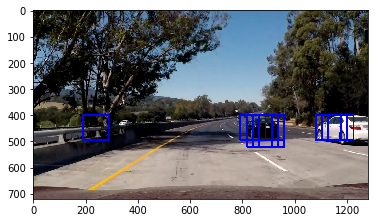

In [17]:
test_img = mpimg.imread('./test_images/test5.jpg')

ystart = 400
ystop = 650
scale = 1.5

svc = loaded_svc
X_scaler = loaded_X_scaler

color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32, 32)
hist_bins = 32

out_img, bboxes = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, 
              color_space, orient, pix_per_cell, cell_per_block, hog_channel,
              spatial_size, hist_bins)

plt.imshow(out_img)
print(len(bboxes))

In [18]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

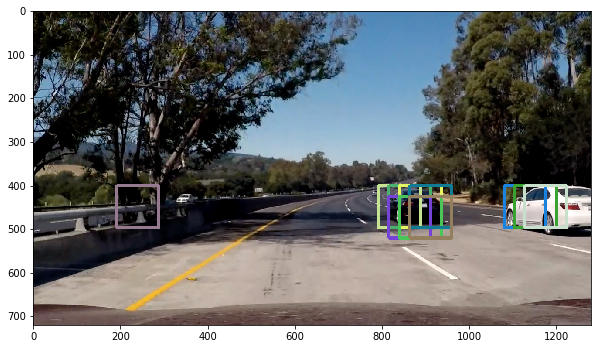

In [19]:
test_img_identified = draw_boxes(test_img, bboxes, color = 'random')
plt.figure(figsize=(10,10))
plt.imshow(test_img_identified)

ystart:  400, ystop:  464, scale:  1.0
ystart:  416, ystop:  480, scale:  1.0
154


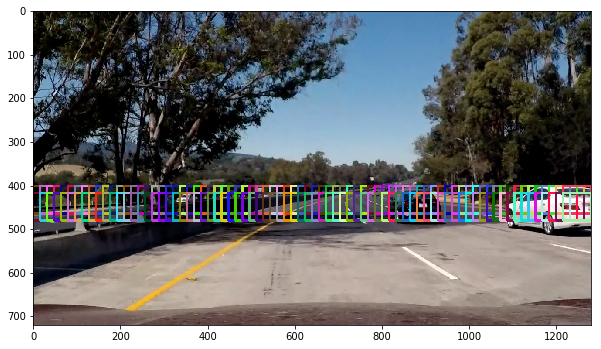

In [20]:
bboxes = []
window = 64
step_size = 16
scales = [1.0, 1.5, 2.0, 3.0]

idx = 0
scale = scales[idx]
ystart = 400
ystop = ystart + int(window * scale)
print("ystart: {:4d}, ystop: {:4d}, scale: {:4}".format(ystart, ystop, scale))
_, sub_bboxes = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, 
              color_space, orient, pix_per_cell, cell_per_block, hog_channel,
              spatial_size, hist_bins, show_boxes = True)
for item in sub_bboxes:
    bboxes.append(item)

ystart = 400 + int(step_size * scale)
ystop = ystart + int(window * scale)
print("ystart: {:4d}, ystop: {:4d}, scale: {:4}".format(ystart, ystop, scale))
_, sub_bboxes = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, 
              color_space, orient, pix_per_cell, cell_per_block, hog_channel,
              spatial_size, hist_bins, show_boxes = True)
for item in sub_bboxes:
    bboxes.append(item)

print(len(bboxes))

test_img_identified = draw_boxes(test_img, bboxes, color='random', thick=3)
plt.figure(figsize=(10,10))
plt.imshow(test_img_identified)

ystart:  400, ystop:  496, scale:  1.5
ystart:  424, ystop:  520, scale:  1.5
100


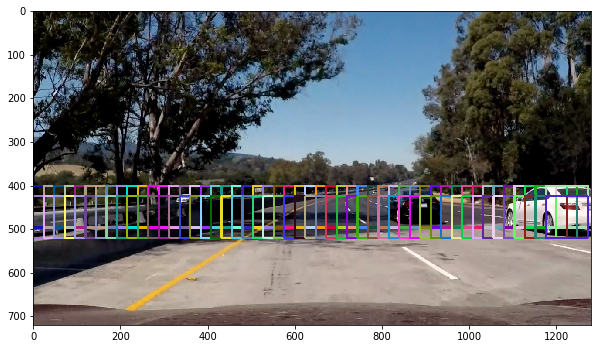

In [21]:
bboxes = []
window = 64
step_size = 16
scales = [1.0, 1.5, 2.0, 3.0]

idx = 1
scale = scales[idx]
ystart = 400
ystop = ystart + int(window * scale)
print("ystart: {:4d}, ystop: {:4d}, scale: {:4}".format(ystart, ystop, scale))
_, sub_bboxes = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, 
              color_space, orient, pix_per_cell, cell_per_block, hog_channel,
              spatial_size, hist_bins, show_boxes = True)
for item in sub_bboxes:
    bboxes.append(item)

ystart = 400 + int(step_size * scale)
ystop = ystart + int(window * scale)
print("ystart: {:4d}, ystop: {:4d}, scale: {:4}".format(ystart, ystop, scale))
_, sub_bboxes = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, 
              color_space, orient, pix_per_cell, cell_per_block, hog_channel,
              spatial_size, hist_bins, show_boxes = True)
for item in sub_bboxes:
    bboxes.append(item)

print(len(bboxes))

test_img_identified = draw_boxes(test_img, bboxes, color='random', thick=3)
plt.figure(figsize=(10,10))
plt.imshow(test_img_identified)

ystart:  400, ystop:  528, scale:  2.0
ystart:  432, ystop:  560, scale:  2.0
74


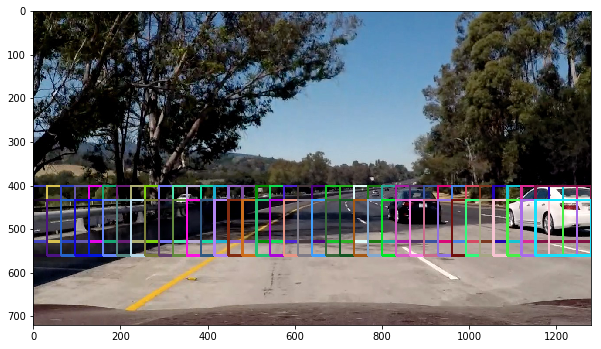

In [22]:
bboxes = []
window = 64
step_size = 16
scales = [1.0, 1.5, 2.0, 3.0]

idx = 2
scale = scales[idx]
ystart = 400
ystop = ystart + int(window * scale)
print("ystart: {:4d}, ystop: {:4d}, scale: {:4}".format(ystart, ystop, scale))
_, sub_bboxes = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, 
              color_space, orient, pix_per_cell, cell_per_block, hog_channel,
              spatial_size, hist_bins, show_boxes = True)
for item in sub_bboxes:
    bboxes.append(item)

ystart = 400 + int(step_size * scale)
ystop = ystart + int(window * scale)
print("ystart: {:4d}, ystop: {:4d}, scale: {:4}".format(ystart, ystop, scale))
_, sub_bboxes = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, 
              color_space, orient, pix_per_cell, cell_per_block, hog_channel,
              spatial_size, hist_bins, show_boxes = True)
for item in sub_bboxes:
    bboxes.append(item)

print(len(bboxes))

test_img_identified = draw_boxes(test_img, bboxes, color='random', thick=3)
plt.figure(figsize=(10,10))
plt.imshow(test_img_identified)

ystart:  400, ystop:  592, scale:  3.0
ystart:  448, ystop:  640, scale:  3.0
46


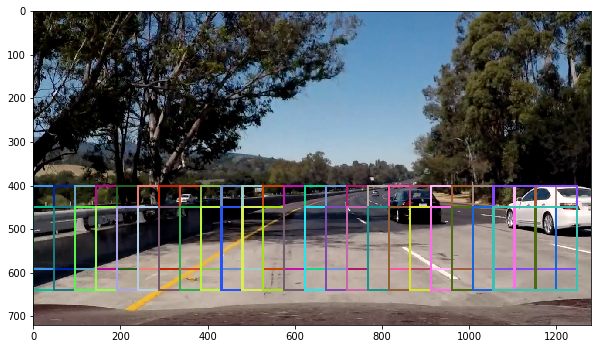

In [23]:
bboxes = []
window = 64
step_size = 16
scales = [1.0, 1.5, 2.0, 3.0]

idx = 3
scale = scales[idx]
ystart = 400
ystop = ystart + int(window * scale)
print("ystart: {:4d}, ystop: {:4d}, scale: {:4}".format(ystart, ystop, scale))
_, sub_bboxes = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, 
              color_space, orient, pix_per_cell, cell_per_block, hog_channel,
              spatial_size, hist_bins, show_boxes = True)
for item in sub_bboxes:
    bboxes.append(item)

ystart = 400 + int(step_size * scale)
ystop = ystart + int(window * scale)
print("ystart: {:4d}, ystop: {:4d}, scale: {:4}".format(ystart, ystop, scale))
_, sub_bboxes = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, 
              color_space, orient, pix_per_cell, cell_per_block, hog_channel,
              spatial_size, hist_bins, show_boxes = True)
for item in sub_bboxes:
    bboxes.append(item)

print(len(bboxes))

test_img_identified = draw_boxes(test_img, bboxes, color='random', thick=3)
plt.figure(figsize=(10,10))
plt.imshow(test_img_identified)

ystart:  400, ystop:  464, scale:  1.0
ystart:  416, ystop:  480, scale:  1.0
ystart:  400, ystop:  496, scale:  1.5
ystart:  424, ystop:  520, scale:  1.5
ystart:  400, ystop:  528, scale:  2.0
ystart:  432, ystop:  560, scale:  2.0
ystart:  400, ystop:  592, scale:  3.0
ystart:  448, ystop:  640, scale:  3.0
374


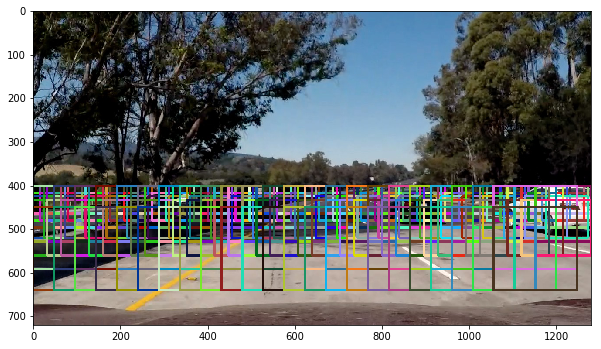

In [24]:
bboxes = []
window = 64
step_size = 16
scales = [1.0, 1.5, 2.0, 3.0]

for scale in scales:
    
    ystart = 400
    ystop = ystart + int(window * scale)
    print("ystart: {:4d}, ystop: {:4d}, scale: {:4}".format(ystart, ystop, scale))
    _, sub_bboxes = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, 
                  color_space, orient, pix_per_cell, cell_per_block, hog_channel,
                  spatial_size, hist_bins, show_boxes = True)
    for item in sub_bboxes:
        bboxes.append(item)

    ystart = 400 + int(step_size * scale)
    ystop = ystart + int(window * scale)
    print("ystart: {:4d}, ystop: {:4d}, scale: {:4}".format(ystart, ystop, scale))
    _, sub_bboxes = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, 
                  color_space, orient, pix_per_cell, cell_per_block, hog_channel,
                  spatial_size, hist_bins, show_boxes = True)
    for item in sub_bboxes:
        bboxes.append(item)

print(len(bboxes))

test_img_identified = draw_boxes(test_img, bboxes, color='random', thick=3)
plt.figure(figsize=(10,10))
plt.imshow(test_img_identified)

19


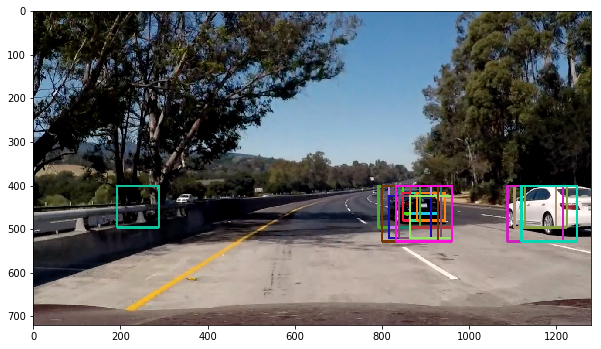

In [25]:
bboxes = []
window = 64
step_size = 16
scales = [1.0, 1.5, 2.0, 3.0]

for scale in scales:
    
    ystart = 400
    ystop = ystart + int(window * scale)
    # print("ystart: {:4d}, ystop: {:4d}, scale: {:4}".format(ystart, ystop, scale))
    _, sub_bboxes = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, 
                  color_space, orient, pix_per_cell, cell_per_block, hog_channel,
                  spatial_size, hist_bins)
    for item in sub_bboxes:
        bboxes.append(item)

    ystart = 400 + int(step_size * scale)
    ystop = ystart + int(window * scale)
    # print("ystart: {:4d}, ystop: {:4d}, scale: {:4}".format(ystart, ystop, scale))
    _, sub_bboxes = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, 
                  color_space, orient, pix_per_cell, cell_per_block, hog_channel,
                  spatial_size, hist_bins)
    for item in sub_bboxes:
        bboxes.append(item)

print(len(bboxes))

test_img_identified = draw_boxes(test_img, bboxes, color='random', thick=3)
plt.figure(figsize=(10,10))
plt.imshow(test_img_identified)

### 2. Show some examples of test images to demonstrate how your pipeline is working. What did you do to optimize the performance of your classifier?

#### Heatmap

In [26]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

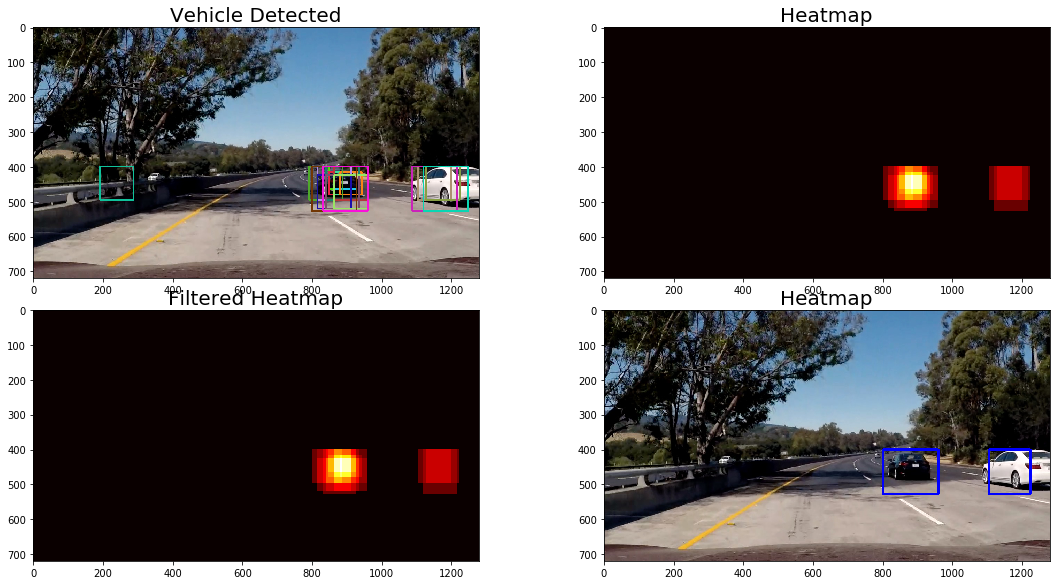

In [37]:
heat = np.zeros_like(test_img_identified[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,bboxes)
    
# Apply threshold to help remove false positives
heat_filt = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat_filt, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test_img), labels)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))
f.tight_layout()
ax1.imshow(test_img_identified)
ax1.set_title('Vehicle Detected', fontsize=20)
ax2.imshow(heat, cmap='hot')
ax2.set_title('Heatmap', fontsize=20)
ax3.imshow(heatmap, cmap='hot')
ax3.set_title('Filtered Heatmap', fontsize=20)
ax4.imshow(draw_img)
ax4.set_title('Heatmap', fontsize=20)

In [28]:
def pipline(img):
    
    svc = loaded_svc
    X_scaler = loaded_X_scaler

    color_space = 'YCrCb'
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL'
    spatial_size = (32, 32)
    hist_bins = 32

    bboxes = list()
    window = 64
    step_size = 16
    scales = [1.0, 1.5, 2.0, 3.0]

    for scale in scales:

        ystart = 400
        ystop = ystart + int(window * scale)
        # print("ystart: {:4d}, ystop: {:4d}, scale: {:4}".format(ystart, ystop, scale))
        _, sub_bboxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, 
                      color_space, orient, pix_per_cell, cell_per_block, hog_channel,
                      spatial_size, hist_bins)
        for item in sub_bboxes:
            bboxes.append(item)

        ystart = 400 + int(step_size * scale)
        ystop = ystart + int(window * scale)
        # print("ystart: {:4d}, ystop: {:4d}, scale: {:4}".format(ystart, ystop, scale))
        _, sub_bboxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, 
                      color_space, orient, pix_per_cell, cell_per_block, hog_channel,
                      spatial_size, hist_bins)
        for item in sub_bboxes:
            bboxes.append(item)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,bboxes)

    # Apply threshold to help remove false positives
    heat_filt = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_filt, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

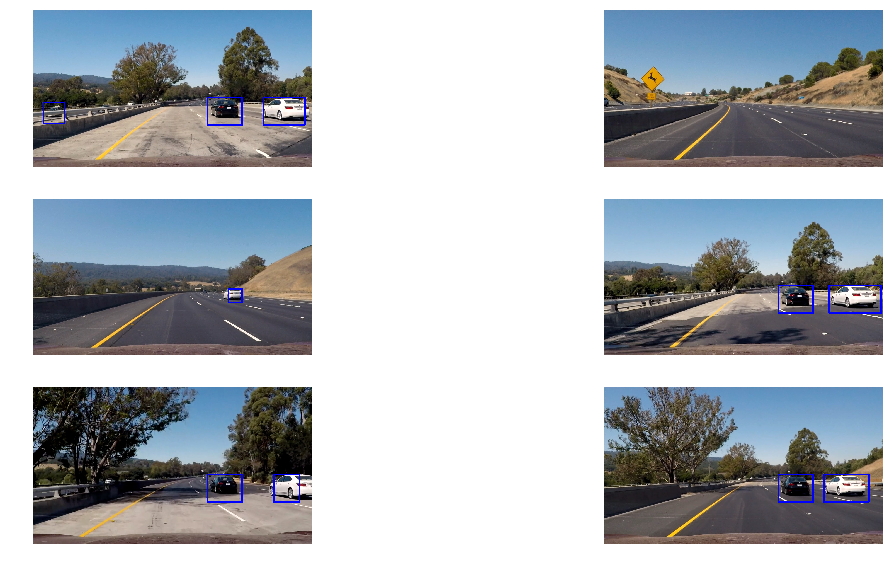

In [29]:
test_images = glob.glob('./test_images/test*.jpg')

f, axs = plt.subplots(3, 2, figsize=(16, 8))
f.tight_layout()
axs = axs.ravel()

for i, img in enumerate(test_images):
    img = mpimg.imread(img)
    draw_img = pipline(img)
    axs[i].imshow(draw_img)
    axs[i].axis('off')


## Video Implementation

### 1. Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

In [30]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(pipline)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:27<00:00,  1.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 28.2 s


### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

In [31]:
class Bboxes_Store():
    def __init__(self):
        self.bboxes_prev = list()
        
    def add_bboxes(self, bboxes):
        self.bboxes_prev.append(bboxes)
        if len(self.bboxes_prev) > 15:
            # throw out oldest ones
            self.bboxes_prev = self.bboxes_prev[len(self.bboxes_prev)-15:]

In [32]:
def pipline_video(img):
    
    svc = loaded_svc
    X_scaler = loaded_X_scaler

    color_space = 'YCrCb'
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL'
    spatial_size = (32, 32)
    hist_bins = 32

    bboxes = list()
    window = 64
    step_size = 16
    scales = [1.0, 1.5, 2.0, 3.0]

    for scale in scales:

        ystart = 400
        ystop = ystart + int(window * scale)
        # print("ystart: {:4d}, ystop: {:4d}, scale: {:4}".format(ystart, ystop, scale))
        _, sub_bboxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, 
                      color_space, orient, pix_per_cell, cell_per_block, hog_channel,
                      spatial_size, hist_bins)
        for item in sub_bboxes:
            bboxes.append(item)

        ystart = 400 + int(step_size * scale)
        ystop = ystart + int(window * scale)
        # print("ystart: {:4d}, ystop: {:4d}, scale: {:4}".format(ystart, ystop, scale))
        _, sub_bboxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, 
                      color_space, orient, pix_per_cell, cell_per_block, hog_channel,
                      spatial_size, hist_bins)
        for item in sub_bboxes:
            bboxes.append(item)
    
    
    if len(bboxes) > 0:
        bboxes_storage.add_bboxes(bboxes)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    for bboxes in bboxes_storage.bboxes_prev:
        heat = add_heat(heat,bboxes)

    # Apply threshold to help remove false positives
    heat_filt = apply_threshold(heat,1 + int(len(bboxes_storage.bboxes_prev)//2))

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_filt, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

In [33]:
bboxes_storage = Bboxes_Store()

test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(pipline_video)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:27<00:00,  1.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 27.7 s


In [34]:
bboxes_storage = Bboxes_Store()

project_out_file = 'project_video_out.mp4'
clip_project = VideoFileClip('project_video.mp4') #.subclip(23,26)  # subclip = only specified span of video
#clip_proj.save_frame('./test_images/project1.jpg', t=1.0) # saves the frame at time = t seconds
clip_project_out = clip_project.fl_image(pipline_video)
%time clip_project_out.write_videofile(project_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [15:03<00:00,  1.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 15min 3s


## Discussion

### 1. Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

## Acknowledgement

1. [jeremy shannon's work](https://github.com/jeremy-shannon/CarND-Vehicle-Detection/blob/master/vehicle_detection_project.ipynb)
2. [blob's work](https://github.com/ahmadesh/Udacity-CarND-Term1-Vehicle-Detection/blob/master/Project.ipynb)
3. [YOLO](https://pjreddie.com/media/files/papers/yolo.pdf)
